# USA Car Accidents Prediction for 2020
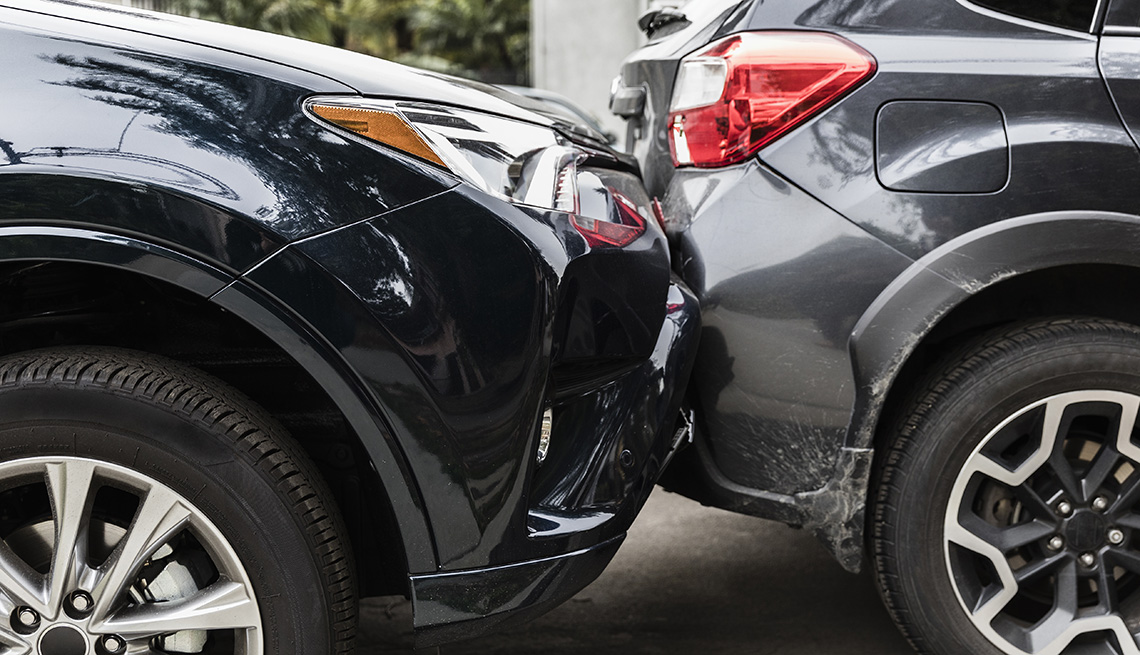

# *Attention*

- If this notebook is ran entirely, I suggest go away from the keyboard and
come back after 30 minutes. 
- If you computer is well spec'd then it will go faster!
- Ran time will be printed at the bottom.

# Analysis:

- Machine Learning Problem: Classification
- Date Range: Feb 8 2016 through Jun 30 2020
- Target: Severity (impact of traffic flow)
- Train: Feb 2016 through Dec 2018
- Validation: 2019
- Test: Jan through Jun of 2020

# Added Features:

- Duration of accident
- Distance in feet
- Length of description
- Kind of street
- Calendar information

# Import and Setup

In [ ]:
%%capture
# To time the whole notebook:
from time import time
start_time = time()

# Other:
import catboost
from catboost import CatBoostClassifier, Pool
from pdpbox.pdp import pdp_isolate, pdp_interact, pdp_plot, pdp_interact_plot
import seaborn as sns
import shap
from tqdm.notebook import tqdm
from xgboost import XGBClassifier

# Libraries:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
from pandas_profiling import ProfileReport

# Category:
import category_encoders
from category_encoders import OrdinalEncoder, OneHotEncoder

# Sklearn:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.metrics import accuracy_score, confusion_matrix, plot_confusion_matrix, plot_roc_curve
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.linear_model import Perceptron, LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, label_binarize
from sklearn.tree import DecisionTreeClassifier

In [ ]:
# This code enables intellisense.
%config IPCompleter.greedy=True

In [ ]:
# To display all columns and more rows.
pd.options.display.max_columns = None
pd.options.display.max_rows = 100

# This code is to ignore copy warnings.
pd.options.mode.chained_assignment = None

In [ ]:
# This will set the style for all
# bar plots:
plt.style.use('fivethirtyeight')

In [ ]:
# CSV Links from my repo!
acc = 'https://media.githubusercontent.com/media/Lolo-17/USA-Car-Accident-Prediction/master/CSV%20Files/US_Accidents_June20.csv'
stt = 'https://media.githubusercontent.com/media/Lolo-17/USA-Car-Accident-Prediction/master/CSV%20Files/Street_Kind_Column.csv'
dur = 'https://media.githubusercontent.com/media/Lolo-17/USA-Car-Accident-Prediction/master/CSV%20Files/Duration_Column.csv'

In [ ]:
# Reading my us accidents dataset and parsing dates.
USA_Accidents = pd.read_csv(acc, 
                            infer_datetime_format=True, parse_dates=['Start_Time', 'End_Time'])

# Reading street_kind column to concat into main dataframe.
Street_Kind = pd.read_csv(stt)

# Reading time duration column to concat into main dataframe.
Duration = pd.read_csv(dur)

In [ ]:
# Making a copy so I don't have to re-run this giant
# dataset of 3.5 million observations.
df = USA_Accidents.copy()

In [ ]:
%%capture

# This create a pandas profile report and saves
# a html link in current directory.
profile = ProfileReport(df, minimal=True)
profile.to_file("Pandas Profile.html")

# EDA

In [ ]:
# To display shape of dataframe and first 5 rows.
print('Shape of USA Car Accidents Dataframe:', df.shape)
df.head()

In [ ]:
# To inspect datatypes and null value counts.
df.info(verbose=True, null_counts=True)

In [ ]:
# This is to compare if my for loop in a another
# notebook did a good job at picking up string values
# from the street column and creating the street kind column.
a = df['Street']
b = Street_Kind['Street_Kind']
ab = pd.concat([a,b], axis=1)
ab[2000025:2000050]

# Wrangling

In [ ]:
# Concatenating street kind and duration columns into main dataframe.
df = pd.concat([df, Street_Kind], axis=1)
df = pd.concat([df, Duration], axis=1)

# Changing index to year.
df.index = pd.DatetimeIndex(df['Start_Time']).year
df.index.name = 'Year'

# Changing target feature for better readability.
df['Severity'] = df['Severity'].replace({1:'Least Impact', 
                                         2:'Impactful', 
                                         3:'More Impactful', 
                                         4:'Significant Impact'})

# Creating new features of calendar statistics.
# 1.) Month name abbreviated.
# 2.) Day of the month as integer.
# 3.) The weekday name.
# 4.) Week number of the year.
# 5.) Weekend yes or no.
# 6.) Hour of day.
df['Month'] = df['Start_Time'].dt.strftime('%B')
df['Day_of_Month'] = (df['Start_Time'].dt.day)
df['Weekday'] = df['Start_Time'].dt.strftime('%A')
df['Week_Num_Year'] = df['Start_Time'].dt.strftime('%W')
df['Weekend'] = ((df['Weekday'] == 'Saturday') | (df['Weekday'] == 'Sunday')).astype('int64')
df['Hour_of_Day'] = df['Start_Time'].dt.strftime('%H')

# Creating a new feature of accident distance effect in feet.
df['Distance_Feet'] = df['Distance(mi)'] * 5280

# Creating a new feature of description lenght.
df['Description_Length'] = (df['Description'].str.len()).astype(object)

# Changing this column to only display timezone.
df['Timezone'] = df['Timezone'].str.strip('US/')

# A list of columns with boolean values.
bools = ['Bump', 'Crossing', 'Railway', 'Stop', 
         'Traffic_Calming', 'Traffic_Signal']

# To replace with ones and zeros.
df[bools] = df[bools].replace({False:0,
                                True:1})

# To sort dataframe by year.
df = df.sort_index()

In [ ]:
# To view all columns and to select keeping
# columns easily.
df.columns

In [ ]:
# These are the features I am keeping for my ML models.
keeping = ['Month', 'Day_of_Month', 'Weekday', 'Week_Num_Year', 'Weekend', 'Hour_of_Day',
           'Timezone', 'State', 'City', 'Airport_Code', 'Start_Lat', 'Start_Lng', 'Side', 
           'Street_Kind', 'Temperature(F)', 'Humidity(%)', 'Visibility(mi)', 'Wind_Direction', 
           'Wind_Speed(mph)', 'Precipitation(in)', 'Weather_Condition', 'Bump', 'Crossing',
           'Railway', 'Stop', 'Traffic_Calming', 'Traffic_Signal','Sunrise_Sunset', 'Duration',  
           'Distance_Feet', 'Description_Length',  'Source', 'Severity'
]

# Replace df with keeping columns.
df = df[keeping]

In [ ]:
# New dataframe after engineering.
df.head()

# Split Data

In [ ]:
target = 'Severity'
y = df[target]
X = df.drop(target, axis=1)

In [ ]:
# Train: Feb 2016 through Dec 2018
# Validation: 2019
# Test: Jan through Jun of 2020

tr_dt = df.index < 2019
vl_dt = df.index  == 2019
tt_dt = df.index  == 2020

X_train, y_train = X.loc[tr_dt], y.loc[tr_dt]
X_val, y_val = X.loc[vl_dt], y.loc[vl_dt]
X_test, y_test = X.loc[tt_dt], y.loc[tt_dt]

## Shapes

In [ ]:
print('X Training Data Shape', X_train.shape)
print('X Validation Data Shape', X_val.shape)
print('X Test Data Shape', X_test.shape)

In [ ]:
print('y Training Data Shape', y_train.shape)
print('y Validation Data Shape', y_val.shape)
print('y Test Data Shape', y_test.shape)

# Baseline

In [ ]:
print('Value counts of car accidents severity impact on traffic flow:')
print(y.value_counts())

In [ ]:
print('Ratio of car accidents severity impact on traffic:')
print(y.value_counts(normalize=True))

In [ ]:
print('Baseline Accuracy of car accidents severity impact on traffic:', 
      round(y.value_counts(normalize=True).max(),3))

# Models

## `OrdinalEncoder` + `CatBoostClassifier`
- To be used in heroku app

In [ ]:
%%capture

kbest = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    SelectKBest(k=16),
    CatBoostClassifier(iterations=10)
)

kbest.fit(X_train, y_train);

kcols = X_train.columns[kbest.named_steps['selectkbest'].get_support()].drop(labels=['Timezone', 
                                                                             'City', 
                                                                             'Start_Lat', 
                                                                             'Start_Lng', 
                                                                             'Source', 
                                                                             'Airport_Code'])
X_train = X_train[kcols]
X_val= X_val[kcols]
X_test = X_test[kcols]

In [ ]:
ord_cat_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(), 
    CatBoostClassifier(iterations=500, random_state=17, learning_rate=0.85),
    verbose=True
)

ord_cat_model.fit(X_train, y_train);

## For Visual Studio Code

In [ ]:
X_train.Hour_of_Day = X_train.Hour_of_Day.astype('int64')

import joblib
from joblib import dump

print(f'CatBoost=={catboost.__version__}')
print(f'category_encoders=={category_encoders.__version__}')
print(f'joblib=={joblib.__version__}')

dump(ord_cat_model, 'CatBoost.joblib', compress=True)

### Metrics

In [ ]:
cat_train_score = round(ord_cat_model.score(X_train, y_train),3)
cat_val_score = round(ord_cat_model.score(X_val, y_val),3)
cat_test_score = round(ord_cat_model.score(X_test, y_test),3)

print('CatBoost Training Accuracy:', cat_train_score)
print('CatBoost Validation Accuracy:', cat_val_score)
print('CatBoost Test Accuracy:', cat_test_score)

In [ ]:
fig, ax1 = plt.subplots(figsize=(9,6))

plot_confusion_matrix(ord_cat_model, X_test, y_test, 
                      normalize='true', ax=ax1, xticks_rotation='vertical')

ax1.set_title('CatBoost Confusion Matrix', fontsize=14, fontweight='bold')
ax1.grid(False)
plt.tight_layout()
plt.savefig('Confusion Matrix from CatBoost')
plt.show()

### Cross-Validation

In [ ]:
test_ord_cat_c = cross_val_score(ord_cat_model, X_test, y_test,
                                         cv=5, n_jobs=-1, scoring='accuracy', verbose=True)

In [ ]:
print('CatBoost Test Cross Validation Score Mean [5 Folds]:', round(test_ord_cat_c.mean(),3))

### Tuning
- With `RandomizedSearchCV`

In [ ]:
cat_params = {
              'catboostclassifier__depth':range(1,16,4),
              'catboostclassifier__learning_rate':[.75,.85,.95],
              'catboostclassifier__l2_leaf_reg':range(1,101,30),
              'catboostclassifier__iterations':[10]
             }

In [ ]:
ord_rs_cat_model = RandomizedSearchCV(
    ord_cat_model,
    cat_params, 
    n_iter=1, 
    cv=10, 
    verbose=1, 
    n_jobs=-1
)

ord_rs_cat_model.fit(X_train, y_train);

In [ ]:
rs_cat_train_score = round(ord_rs_cat_model.score(X_train, y_train),3)
rs_cat_val_score = round(ord_rs_cat_model.score(X_val, y_val),3)
rs_cat_test_score = round(ord_rs_cat_model.score(X_test, y_test),3)

print('Randomized Search With CatBoost Training Accuracy:', rs_cat_train_score)
print('Randomized Search With CatBoost Validation Accuracy:', rs_cat_val_score)
print('Randomized Search With CatBoost Test Accuracy:', rs_cat_test_score)

## `OrdinalEncoder` + `LogisticRegression`

In [ ]:
ord_ltr_model = make_pipeline(
    OrdinalEncoder(),
    StandardScaler(),
    SimpleImputer(),
    LogisticRegression(penalty='elasticnet', random_state=17, l1_ratio=.40,
                       solver='saga', max_iter=100, multi_class='ovr', n_jobs=-1,
                       C=.10),
    verbose=True
)

ord_ltr_model.fit(X_train, y_train);

### Metrics

In [ ]:
ltr_train_score = round(ord_ltr_model.score(X_train, y_train),3)
ltr_val_score = round(ord_ltr_model.score(X_val, y_val),3)
ltr_test_score = round(ord_ltr_model.score(X_test, y_test),3)

print('Logistic Training Accuracy:', ltr_train_score)
print('Logistic Validation Accuracy:', ltr_val_score)
print('Logistic Test Accuracy:', ltr_test_score)

In [ ]:
fig, ax1 = plt.subplots(figsize=(9,6))

plot_confusion_matrix(ord_ltr_model, X_test, y_test,
                      normalize='true', ax=ax1, xticks_rotation='vertical')

ax1.set_title('Logistic Regression Confusion Matrix', fontsize=12, fontweight='bold')
ax1.grid(False)
plt.tight_layout()
plt.savefig('Confusion Matrix from LogisticRegression')
plt.show()

### Cross-Validation

In [ ]:
test_ord_ltr_c = cross_val_score(ord_ltr_model, X_test, y_test,
                                         cv=5, n_jobs=-1, scoring='accuracy', verbose=True)

In [ ]:
print('Logistic Regression Test Cross Validation Score Mean [5 Folds]:', round(test_ord_ltr_c.mean(),3))

### Tuning
- With `RandomizedSearchCV`

In [ ]:
ltr_params = {
              'logisticregression__max_iter':[10],
             }

In [ ]:
ord_rs_ltr_model = RandomizedSearchCV(
    ord_ltr_model,
    ltr_params, 
    n_iter=1, 
    cv=10, 
    verbose=1, 
    n_jobs=-1
)

ord_rs_ltr_model.fit(X_train, y_train);

In [ ]:
rs_ltr_train_score = round(ord_rs_ltr_model.score(X_train, y_train),3)
rs_ltr_val_score = round(ord_rs_ltr_model.score(X_val, y_val),3)
rs_ltr_test_score = round(ord_rs_ltr_model.score(X_test, y_test),3)

print('Randomized Search With Logistic Regression Training Accuracy:', rs_ltr_train_score)
print('Randomized Search With Logistic Regression Validation Accuracy:', rs_ltr_val_score)
print('Randomized Search With Logistic Regression Test Accuracy:', rs_ltr_test_score)

## `OrdinalEncoder` + `RandomForestClassifier`

In [ ]:
ord_forest_model = make_pipeline(
    OrdinalEncoder(),
    SimpleImputer(),
    RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=17, 
                           bootstrap=True, warm_start=True, oob_score=True),
    verbose=True
)

ord_forest_model.fit(X_train, y_train);

### Metrics

In [ ]:
forest_train_score = round(ord_forest_model.score(X_train, y_train),3)
forest_val_score = round(ord_forest_model.score(X_val, y_val),3)
forest_test_score = round(ord_forest_model.score(X_test, y_test),3)

print('Random Forest Training Accuracy:', forest_train_score)
print('Random Forest Validation Accuracy:', forest_val_score)
print('Random Forest Test Accuracy:', forest_test_score)

In [ ]:
fig, ax1 = plt.subplots(figsize=(9,6))

plot_confusion_matrix(ord_forest_model, X_test, y_test, 
                      normalize='true', ax=ax1, xticks_rotation='vertical')

ax1.set_title('Random Forest Confusion Matrix', fontsize=12, fontweight='bold')
ax1.grid(False)
plt.tight_layout()
plt.savefig('Confusion Matrix from Forest')
plt.show()

### Cross-Validation

In [ ]:
test_ord_forest_c = cross_val_score(ord_forest_model, X_test, y_test, 
                                    cv=5, n_jobs=-1, scoring='accuracy', verbose=True)

In [ ]:
print('Forest Test Cross Validation Scores [5 Folds]:', round(test_ord_forest_c.mean(),3))

### Tuning
- With `RandomizedSearchCV`

In [ ]:
forest_params = {
              'randomforestclassifier__max_depth':range(1,36,5),
              'randomforestclassifier__n_estimators':[10],
             }

In [ ]:
ord_rs_forest_model = RandomizedSearchCV(
    ord_forest_model,
    forest_params, 
    n_iter=1, 
    cv=10, 
    verbose=1, 
    n_jobs=-1
)

ord_rs_forest_model.fit(X_train, y_train);

In [ ]:
rs_forest_train_score = round(ord_rs_forest_model.score(X_train, y_train),3)
rs_forest_val_score = round(ord_rs_forest_model.score(X_val, y_val),3)
rs_forest_test_score = round(ord_rs_forest_model.score(X_test, y_test),3)

print('Randomized Search With Forest Training Accuracy:', rs_forest_train_score)
print('Randomized Search With Forest Validation Accuracy:', rs_forest_val_score)
print('Randomized Search With Forest Test Accuracy:', rs_forest_test_score)

# Evaluation

## Confusion Matrices

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(ncols=3, nrows=1, figsize=(16,5))

plot_confusion_matrix(ord_cat_model, X_test, y_test, 
                      normalize='true', ax=ax1, xticks_rotation='vertical')

plot_confusion_matrix(ord_ltr_model, X_test, y_test, 
                      normalize='true', ax=ax2, xticks_rotation='vertical')

plot_confusion_matrix(ord_forest_model, X_test, y_test, 
                      normalize='true', ax=ax3, xticks_rotation='vertical')

ax1.set_title('CatBoost Confusion Matrix', fontsize=10, fontweight='bold')
ax2.set_title('Logistic Regression Confusion Matrix', fontsize=10, fontweight='bold')
ax3.set_title('Random Forest Confusion Matrix', fontsize=10, fontweight='bold')
ax1.grid(False)
ax2.grid(False)
ax3.grid(False)
plt.tight_layout()
fig.savefig('Confusion Matrix from Cat-Log-For', dpi=1200)
plt.show()

## Models Scores Perfomances

In [ ]:
base = round(y.value_counts(normalize=True).max(),3) #Baseline
ct = cat_test_score #Ordinal + Catboost test score
cr = rs_cat_test_score #Ordinal + Catboost + Randomized test score
lt = ltr_test_score #Ordinal + Logistic test score
lr = rs_ltr_test_score #Ordinal + Logistic + Randomized test score
ft = forest_test_score #Ordinal + Forest test score
fr = rs_forest_test_score #Ordinal + Forest + Randomized test score

In [ ]:
models = [base, ct, cr, lt, lr, ft, fr]
col_n = ['Ordinal Logistic Randomized', 'Ordinal Logistic', 'Baseline', 'Ordinal CatBoost Randomized', 
         'Ordinal Forest Randomized', 'Ordinal Forest', 'Ordinal Catboost']

In [ ]:
fig, ax = plt.subplots(figsize=(10,8))
ax.barh(col_n, sorted(models), height=.9, label='Classification')

for i, v in enumerate(sorted(models)):
    ax.text(v, i, str(round(v, 3)), va='center', ha='right', color='white',
            fontweight='bold')

ax.set_title("Models Scores Performance", fontsize=14, fontweight='bold')

ax.set_xlabel('Accuracy Test Scores', fontsize=12)

ax.grid(False)

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.legend(bbox_to_anchor=(-.10,1), loc='center')
plt.savefig('Models Scores Performances')
plt.show()

## Cross Validation Models Scores

In [ ]:
tc = test_ord_cat_c.mean() #Ordinal + Catboost cross val test score
tl = test_ord_ltr_c.mean() #Ordinal + Logistic cross val test score
tf = test_ord_forest_c.mean() #Ordinal + Forest cross val test score

In [ ]:
models_c = [base, tc, tl, tf]
col_n_c = ['Baseline', 'Ordinal Logistic', 
         'Ordinal Forest', 'Ordinal Catboost']

In [ ]:
fig, ax = plt.subplots(figsize=(8,4))
ax.barh(col_n_c, sorted(models_c), height=.9, label='Classification')

for i, v in enumerate(sorted(models_c)):
    ax.text(v, i, str(round(v, 3)), va='center', ha='right', color='white',
            fontweight='bold')

ax.set_title("Cross Validation Performance", fontsize=14, fontweight='bold')

ax.set_xlabel('Cross Validation Test Scores', fontsize=12)

ax.grid(False)

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.tight_layout()
plt.legend(bbox_to_anchor=(-.09,1.06), loc='center')
plt.savefig('Models Cross Validation Scores Performancess')
plt.show()

## Permutation Importances
- Model used: `Ordinal + CatBoost`

In [ ]:
col = ['Distance_Feet', 'Street_Kind', 'Description_Length']
X_test_permute = X_test.copy()
X_test_permute[col] = np.random.permutation(X_test_permute[col])

In [ ]:
perm_imp = permutation_importance(ord_cat_model, X_test, y_test, n_jobs=-1,
                                  random_state=17, n_repeats=10)

In [ ]:
data = {'importances_mean' : perm_imp['importances_mean'],
        'importances_std' : perm_imp['importances_std']}

cat_imp = pd.DataFrame(data, index=X_test.columns)
cat_imp.sort_values('importances_mean', ascending=False, inplace=True)

In [ ]:
plt.subplots(figsize=(6,6))

cat_imp.importances_mean.plot(kind='barh', label='Classification')

plt.title('Permutaion Importances', fontsize=14, fontweight='bold')
plt.xlabel('OrdinalEncoder + CatBoost Model', fontsize=12)

plt.legend(bbox_to_anchor=(-.20,1.03), loc='center')
plt.tight_layout()

plt.savefig('Features Permutation from CatBoost')
plt.show()

## PDP Features
- Model used: `Ordinal + CatBoost`

In [ ]:
feature = 'Hour_of_Day'

X_test[feature] = X_test[feature].astype(int)

isolated = pdp_isolate(
    model=ord_cat_model,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature,
    n_jobs=-1
)

pdp_plot(isolated, feature_name=feature, figsize=(12,8))
plt.tight_layout()

plt.savefig('PDP Isolation Hour of Day from CatBoost')
plt.show()

In [ ]:
feature = 'Traffic_Signal'

X_test[feature] = X_test[feature].astype(int)

isolated = pdp_isolate(
    model=ord_cat_model,
    dataset=X_test,
    model_features=X_test.columns,
    feature=feature,
    n_jobs=-1
)

pdp_plot(isolated, feature_name=feature, figsize=(14,8))
plt.tight_layout()

plt.savefig('PDP Isolation Traffic Signal from CatBoost')
plt.show()

# SHAP
- Model used: `Ordinal + CatBoost`

In [ ]:
X_test_sh = X_test.copy()

X_test_sh.Side = X_test_sh.Side.replace({'R':1,
                                         'L':0
})

X_test_sh.Street_Kind = X_test_sh.Street_Kind.replace({'Interstate':1,
                                                     'Highway':2,
                                                     'Road':3,
                                                     'Street':4,
                                                     'Avenue':5,
                                                     'Boulevard':6,
                                                     'Freeway':7,
                                                     'Drive':8,
                                                     'Parkway':9,
                                                     'Expressway':10,
                                                     'Lane':11,
                                                     'Turnpike':12,
                                                     'Pike':13,
                                                     'State Highway':14,
                                                     'Trail':15,
                                                     'Bridge':16,
                                                     'Toll':17,
                                                     'Throughway':18
})
                              
X_test_sh.Sunrise_Sunset = X_test_sh.Sunrise_Sunset.replace({'Day':1,
                                                             'Night':0
})

X_test_sh.Sunrise_Sunset = X_test_sh.Sunrise_Sunset.fillna(0)

X_test_sh = X_test_sh.astype('int64')

cat_features = list(range(0, X_test_sh.shape[1]))

In [ ]:
shap_cat_model = CatBoostClassifier(iterations=500, random_state=17, learning_rate=0.85)
shap_cat_model.fit(X_test_sh, y_test, cat_features=cat_features, plot=False, verbose=True);

In [ ]:
shap_values = shap_cat_model.get_feature_importance(Pool(X_test_sh, y_test, cat_features=cat_features), 
                                                    type='ShapValues')

In [ ]:
explainer = shap.TreeExplainer(shap_cat_model)
shap_values = explainer.shap_values(X_test_sh)

In [ ]:
shap.summary_plot(shap_values, X_test_sh, plot_type='bar', show=False, plot_size=.5)

plt.title('SHAP Values for Car Accidents Impact on Traffic Dataset', fontsize=12, fontweight='bold')
plt.tight_layout()
plt.savefig('SHAP Summary Plot from CatBoost')
plt.show()

# Other

In [ ]:
df19 = df.copy()
df20 = df.copy()

df19 = df19[df19.index == 2019]
df20 = df20[df20.index == 2020]

df19['Week_Num_Year'] = df19['Week_Num_Year'].astype('int64')
df20['Week_Num_Year'] = df20['Week_Num_Year'].astype('int64')

df19 = df19[df19['Week_Num_Year'] < 29]
df20 = df20[df20['Week_Num_Year'] < 29]

In [ ]:
sns.distplot(df19['Hour_of_Day'], label='2019')
sns.distplot(df20['Hour_of_Day'], label='2020')
plt.title('Jan through June 2019 vs 2020', fontsize=16)
plt.xlabel('Accidents by Hour of Day')
plt.tight_layout()
plt.legend()
plt.savefig('SNS Displot for Hour of Day')
plt.show()

In [ ]:
sns.distplot(df19['Day_of_Month'], label='2019')
sns.distplot(df20['Day_of_Month'], label='2020')
plt.title('Jan through June 2019 vs 2020', fontsize=16)
plt.xlabel('Accidents by Day of the Month')
plt.tight_layout()
plt.legend()
plt.savefig('SNS Displot for Day of the Month')
plt.show()

In [ ]:
sns.distplot(df19['Temperature(F)'], label='2019')
sns.distplot(df20['Temperature(F)'], label='2020')
plt.title('Jan through June 2019 vs 2020', fontsize=16)
plt.xlabel('Accidents by Temperature')
plt.tight_layout()
plt.legend()
plt.savefig('SNS Displot for Temperature')
plt.show()

In [ ]:
end_time = time()
time = end_time - start_time
hours = time//3600
time = time - 3600*hours
minutes = time//60
seconds = time - 60*minutes
print('Notebook Lasted:')
print('%d:%d:%d' %(hours,minutes,seconds))